# Importações

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
from sklearn.impute import KNNImputer
import datetime

# Criando variáveis organizacionais

In [2]:
path = '../raw_data/SP' #caminho geral
files = [f for f in listdir(path) if isfile(join(path, f))] #lista de nomes de arquivos de dados

# Tratamentos iniciais dos dados

## Tratamentos básicos

In [3]:
#---------------------fazer list com os dataframes---------------------
df_list = []
for file in range(0,62): # máximo 62
    df = pd.read_csv(f'../raw_data/SP/{files[file]}', sep=';', skiprows=8, encoding="ISO-8859-1", decimal=',')
    lat_log_alt = pd.read_csv(f'../raw_data/SP/{files[file]}', sep=';', skiprows=4,
                          nrows=3, encoding="ISO-8859-1", decimal=',', names=['lat_lon_alt','valor'])
    df['Estaçao']=files[file].split('_')[4]
    df['Latitude']=lat_log_alt['valor'][0]
    df['Longitude']=lat_log_alt['valor'][1]
    df['Altitude']=lat_log_alt['valor'][2]
    df_list.append(df)
df_list

#---------------------fundir os dataframes no dataframe vazio---------------------
full_df = pd.concat(df_list)
full_df
df2 = full_df.copy()

#---------------------dropar coluna inútil---------------------
df2.drop(columns=["Unnamed: 19"],inplace=True)

#---------------------mudar nome das colunas---------------------
df2= df2.rename(columns={'Data': 'Data',
                                            'Hora UTC': 'Hora(UTC)',
                                            'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'Chuva',
                                            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'Pres',
                                            'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'Pres.max',
                                            'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'Pres.min',
                                            'RADIACAO GLOBAL (Kj/m²)': 'Radiacao',
                                            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'Temp',
                                            'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'Temp.orvalho',
                                            'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'Temp.max',
                                            'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'Temp.min',
                                            'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)': 'Temp.orvalho.max',
                                            'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)': 'Temp.orvalho.min',
                                            'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'Umid.max',
                                            'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'Umid.min',
                                            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'Umid',
                                            'VENTO, DIREÇÃO HORARIA (gr) (° (gr))': 'Dir.vento',
                                            'VENTO, RAJADA MAXIMA (m/s)': 'Rajada.vento',
                                            'VENTO, VELOCIDADE HORARIA (m/s)': 'Vel.vento'})

## Transformação de dados e preenchimento

### Formatando data e hora

In [4]:
%%time
#---------------------colocando data e hora no formato adequado---------------------
#df2["Data"] = pd.to_datetime(df2["Data"])
df2['datahora'] = df2.apply(lambda row: pd.to_datetime(f'{row["Data"]} {row["Hora(UTC)"]}'), axis=1)

CPU times: user 1min 45s, sys: 455 ms, total: 1min 46s
Wall time: 1min 46s


### Transformando chuva em variável categórica

Chuva fraca Precipitação cuja intensidade é menor do que 5,0 mm/h.
Chuva
moderada
Precipitação cuja intensidade está compreendida entre 5,0
e 25 mm/h.
Chuva forte Precipitação cuja intensidade está compreendida entre
25,1 e 50 mm/h.
Chuva muito
forte Precipitação cuja intensidade é maior do que 50,0 mm/h.


In [5]:
# KNNInputer antes de passar pela classificação
# Manter os NAN, estão sendo computados como chuva muito forte
# Retirar arquivos sem dados:
# AVARE                        
# BARRA BONITA                 
# BARRA DO TURVO               
# CRIOSFERA 
# Analisar outros com pouquissimo acumulo de chuva

In [6]:
%%time
#---------------------transformando a chuva em variável categórica---------------------
def classe_chuva(precipitacao):
    mm=precipitacao
    if np.isnan(mm):
        chuva = "NaN"
    if mm == 0:
        chuva = 'nao chove'
    elif mm >0 and mm <=5.0:
        chuva = 'fraca'
    elif mm >5.0 and mm<=25.0:
        chuva = 'moderada'
    elif mm >25.0 and mm<=50:
        chuva = 'forte'
    else:
        chuva = 'muito forte'
    return chuva

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


### Tratando valores nulos de radiação

In [7]:
%%time
#---------------------Tratando valores nulos de radiação---------------------
def tratar_radiacao(hora,radiacao):
    if (hora.hour >= 22) or (hora.hour <= 8):
        if np.isnan(radiacao):
            radiacao = 0
    return radiacao
df2['Radiacao'] = df2.apply(lambda x: tratar_radiacao(x['datahora'],x['Radiacao']),axis=1)

CPU times: user 8.49 s, sys: 296 ms, total: 8.78 s
Wall time: 8.8 s


In [8]:
df2[df2['Estaçao']=='OURINHOS']

,Data,Hora(UTC),Chuva,Pres,Pres.max,Pres.min,Radiacao,Temp,Temp.orvalho,Temp.max,...,Umid.min,Umid,Dir.vento,Rajada.vento,Vel.vento,Estaçao,Latitude,Longitude,Altitude,datahora
0,2020/01/01,0000 UTC,0.0,965.5,965.5,964.2,0.0,27.5,17.3,28.1,...,51.0,54.0,357.0,1.5,0.0,OURINHOS,-22.949,-49.894546,443.49,2020-01-01 00:00:00+00:00
1,2020/01/01,0100 UTC,0.0,966.1,966.2,965.5,0.0,25.7,19.0,27.5,...,54.0,67.0,50.0,2.7,0.7,OURINHOS,-22.949,-49.894546,443.49,2020-01-01 01:00:00+00:00
2,2020/01/01,0200 UTC,0.0,966.4,966.4,966.1,0.0,24.6,19.8,25.7,...,67.0,75.0,13.0,2.7,0.0,OURINHOS,-22.949,-49.894546,443.49,2020-01-01 02:00:00+00:00
3,2020/01/01,0300 UTC,0.0,966.1,966.5,966.1,0.0,23.5,19.5,24.6,...,75.0,78.0,67.0,0.9,0.0,OURINHOS,-22.949,-49.894546,443.49,2020-01-01 03:00:00+00:00
4,2020/01/01,0400 UTC,0.0,966.0,966.2,966.0,0.0,23.2,19.9,23.5,...,78.0,81.0,23.0,0.0,0.0,OURINHOS,-22.949,-49.894546,443.49,2020-01-01 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2020/12/31,1900 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OURINHOS,-22.949,-49.894546,443.49,2020-12-31 19:00:00+00:00
8780,2020/12/31,2000 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OURINHOS,-22.949,-49.894546,443.49,2020-12-31 20:00:00+00:00
8781,2020/12/31,2100 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OURINHOS,-22.949,-49.894546,443.49,2020-12-31 21:00:00+00:00
8782,2020/12/31,2200 UTC,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OURINHOS,-22.949,-49.894546,443.49,2020-12-31 22:00:00+00:00


### Imputer da variável de vento

In [9]:
# %%time
# #---------------------fazer imputer nas colunas de vento---------------------
# imputer = KNNImputer(n_neighbors=2)
# imputer.fit_transform(df2[['Rajada.vento', 'Vel.vento', 'Dir.vento']])

# Explorando os dados

In [10]:
#verificando células nulas
df2.isnull().sum().sort_values(ascending=False)/len(df2)

Chuva               0.244097
Rajada.vento        0.232943
Dir.vento           0.231761
Vel.vento           0.231752
Temp.orvalho.min    0.200281
Temp.orvalho.max    0.199992
Umid.max            0.199079
Umid.min            0.199018
Temp.orvalho        0.195540
Umid                0.195405
Temp.max            0.179400
Temp.min            0.179396
Pres.min            0.178479
Pres.max            0.178460
Temp                0.176578
Pres                0.175649
Radiacao            0.133676
Altitude            0.000000
Latitude            0.000000
Longitude           0.000000
Data                0.000000
Estaçao             0.000000
Hora(UTC)           0.000000
datahora            0.000000
dtype: float64

## Acumulado de chuva por estação

In [11]:
#-----------------------plotando a distribuição das variáveis---------------

df2['Chuva'].groupby(df2['Estaçao']).sum()

Estaçao
BARRETOS                  1803.2
BARUERI                    896.6
BAURU                     2140.0
BEBDOURO                   791.0
BEBEDOURO                  552.2
BERTIOGA                   118.8
BRAGANCA PAULISTA         2352.6
CACHOEIRA PAULISTA         857.0
CAMPOS DO JORDAO          1535.6
CASA BRANCA                717.8
DRACENA                   1457.4
FRANCA                    1282.0
IGUAPE                    3928.2
ITAPEVA                   1734.4
ITAPIRA                    852.4
ITATIAIA                  4422.0
ITUVERAVA                 1037.8
LINS                       690.4
MARILIA                   2534.2
OURINHOS                   654.0
PARATI                    2401.6
PIRACICABA                 624.8
PRADOPOLIS                1385.2
PRESIDENTE PRUDENTE       2211.4
RANCHARIA                 1699.6
SAO CARLOS                2581.0
SAO LUIS DO PARAITINGA     198.8
SAO MIGUEL ARCANJO        1637.2
SAO PAULO - INTERLAGOS    2458.6
SAO PAULO - MIRANTE       2936.0
SA

In [12]:
df2[df2['Estaçao']=='REGISTRO'].isnull().sum()/df2[df2.Estaçao=='REGISTRO'].shape[0]

Data               NaN
Hora(UTC)          NaN
Chuva              NaN
Pres               NaN
Pres.max           NaN
Pres.min           NaN
Radiacao           NaN
Temp               NaN
Temp.orvalho       NaN
Temp.max           NaN
Temp.min           NaN
Temp.orvalho.max   NaN
Temp.orvalho.min   NaN
Umid.max           NaN
Umid.min           NaN
Umid               NaN
Dir.vento          NaN
Rajada.vento       NaN
Vel.vento          NaN
Estaçao            NaN
Latitude           NaN
Longitude          NaN
Altitude           NaN
datahora           NaN
dtype: float64

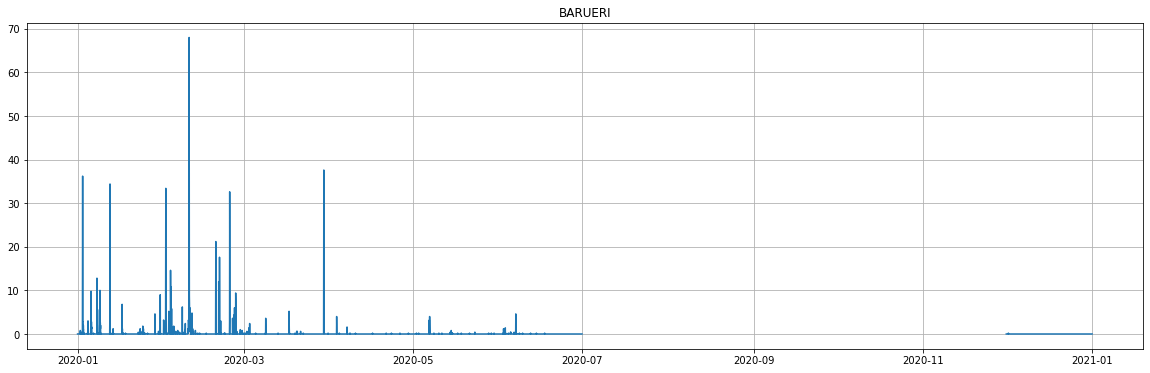

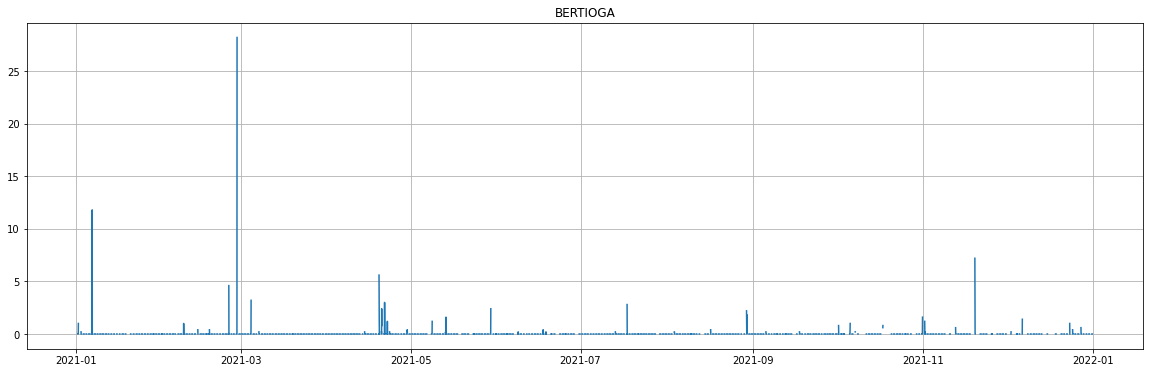

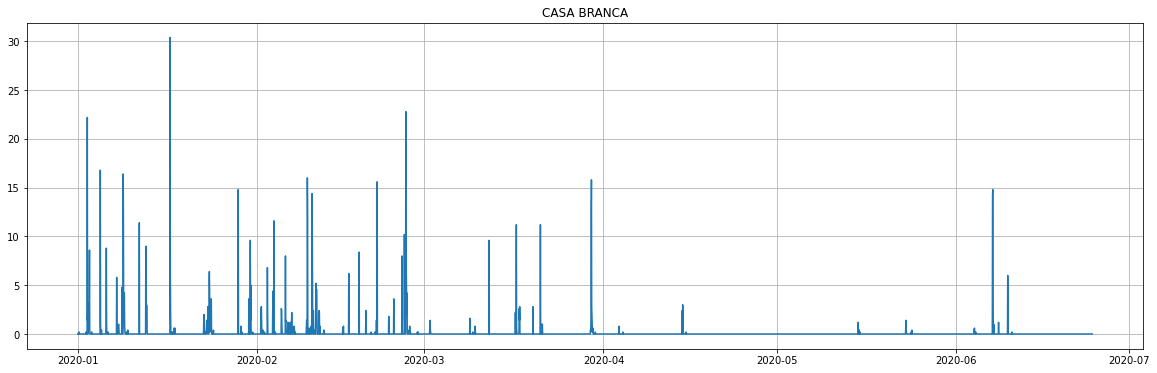

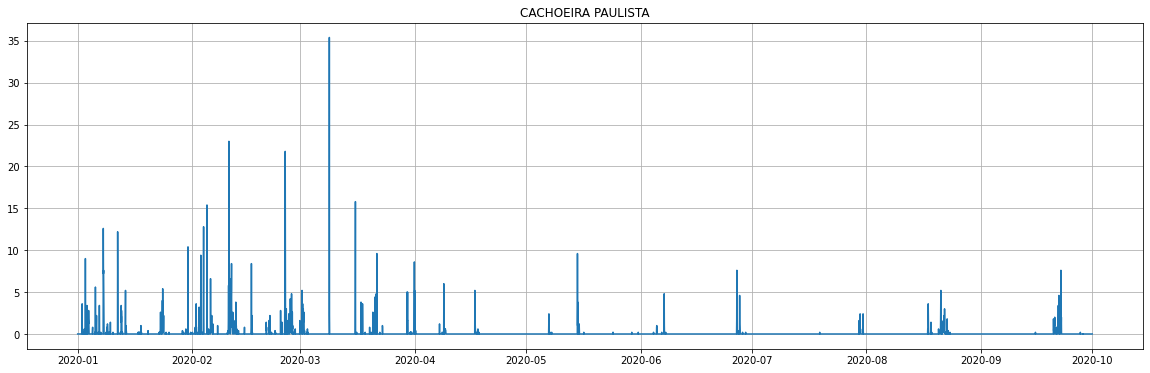

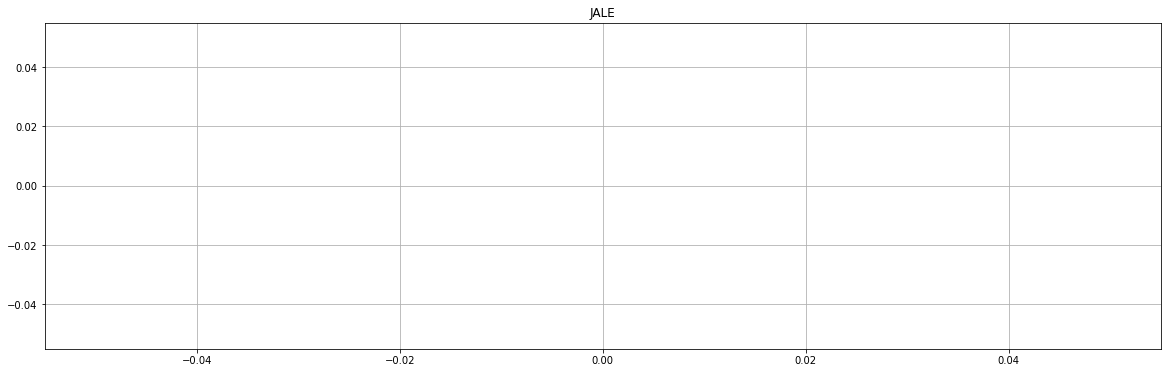

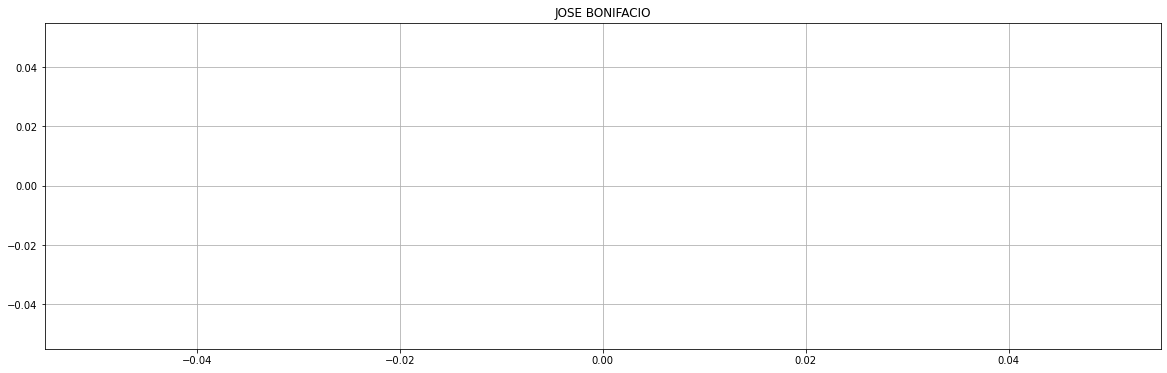

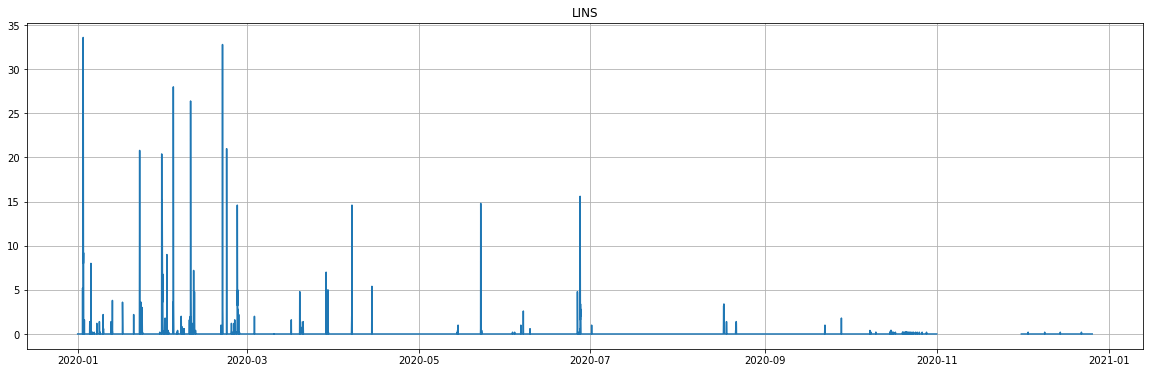

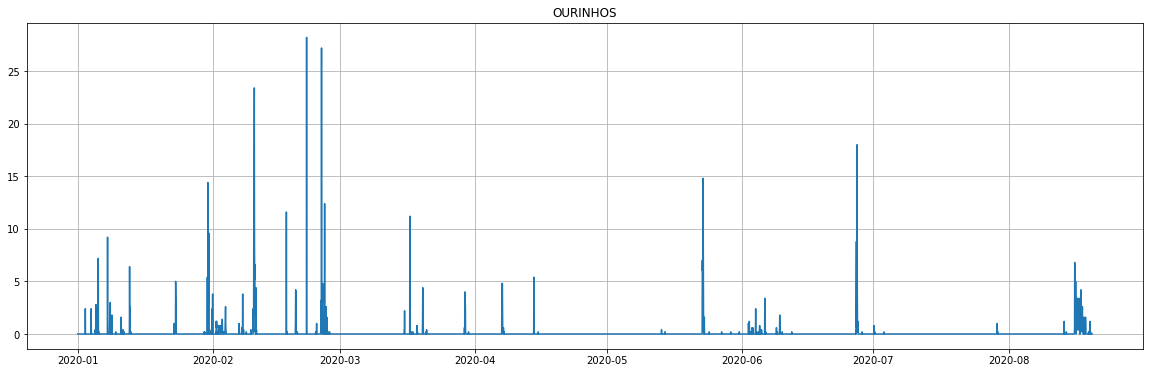

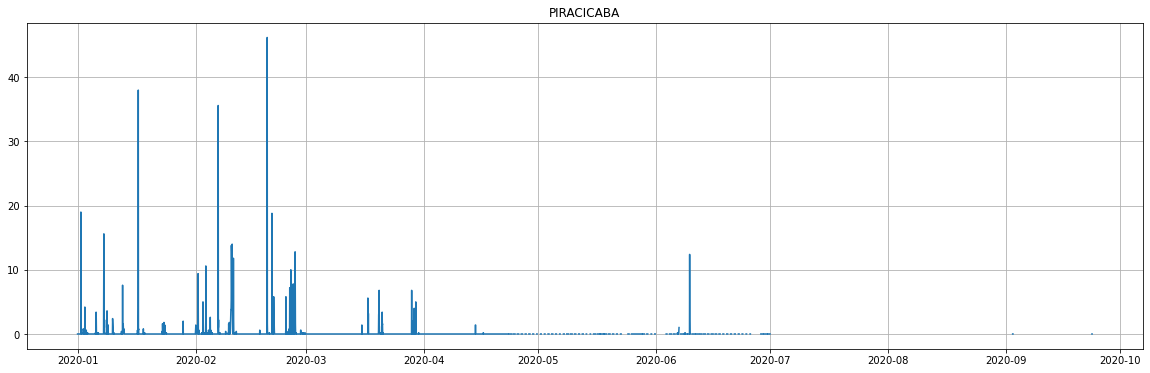

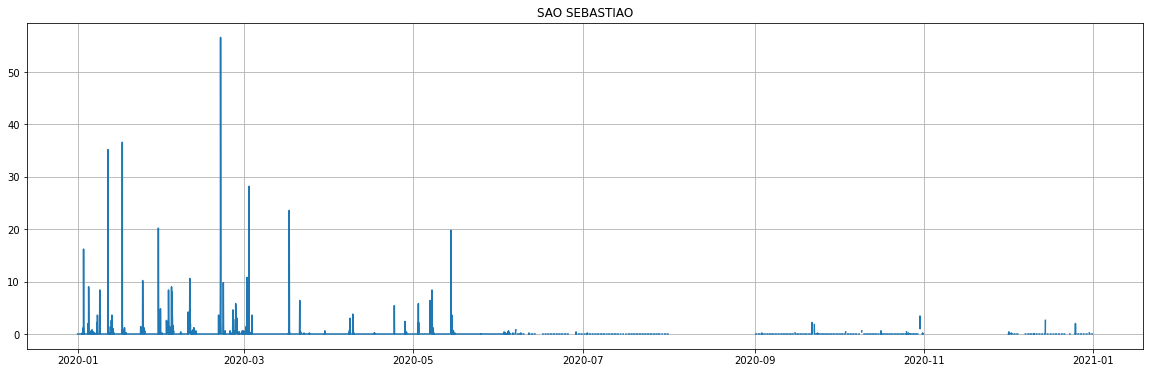

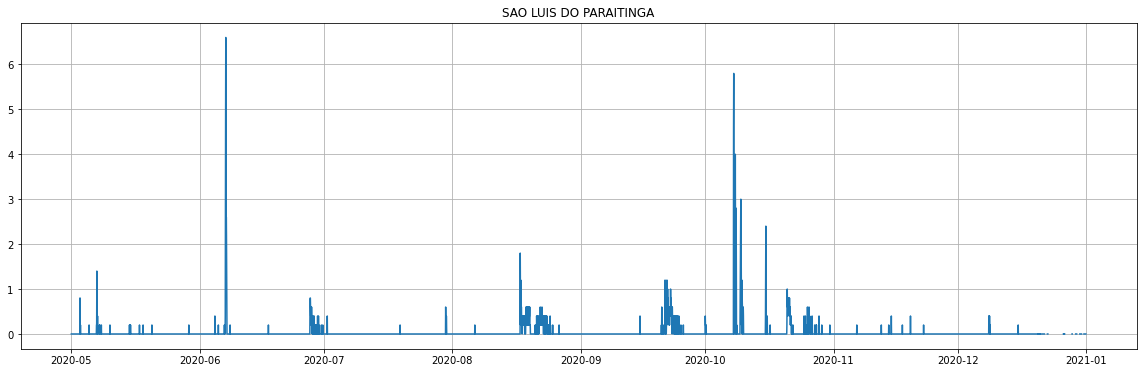

In [13]:
import matplotlib.pyplot as plt

list=['BARUERI', 'BERTIOGA', 'CASA BRANCA', 'CACHOEIRA PAULISTA', 'JALE', 'JOSE BONIFACIO', 'LINS', 
      'OURINHOS', 'PIRACICABA', 'SAO SEBASTIAO', 'SAO LUIS DO PARAITINGA' ]
for city in list:
    dado=df2[df2.Estaçao==city]
    
    fig = plt.figure(figsize=(20,6))
    plt.plot(dado.datahora, dado.Chuva, '-')
    plt.title(city)
    plt.grid()
    plt.show();
    